In [1]:
# | default_exp laplace_approximation
import jax

jax.config.update("jax_enable_x64", True)

# Laplace approximation for log-concave state space models
> See also the corresponding [section in my thesis](https://stefanheyder.github.io/dissertation/thesis.pdf#nameddest=subsection.3.4.1)


Consider an [PGSSM](20_pgssm.ipynb) with states $X$ and observations $Y$.
If the joint distribution of $X$ and $Y$ is not Gaussian, we are unable to perform the standard [Kalman filter and smoother](10_kalman_filter_smoother.ipynb).

Here we implement the alternative Laplace approximation (LA) method from [@Durbin2012Time], Chapter 10.6, which is called mode approximation there. It's main idea is to approximate the posterior distribution by a Gaussian distribution by a second-order Taylor expansion for the log-pdf around the posterior mode.

This essentially means matching the first and second-order derivatives of the observation log-likelihoods at the mode. As the mode is a (global) maximum of the posterior distribution, we can find it by a Newton-Raphson iteration for which [@Durbin2012Time] show, that it can be implemented efficiently by a single pass of a Kalman smoother. 

The LA procedure is based on the observation that at the mode $\hat s = (\hat s_0, \dots, \hat s_n)$ the surrogate Gaussian model with the same state equation and observation equations

$$
\begin{align*}
S_t &= B_t X_t \\
Z_t &= S_t + \eta_t \\
\eta_t &\sim \mathcal N\left(0, \Omega_t\right)
\end{align*}
$$
for $\Omega_t^{-1} = -\frac{\partial^2 \log p(y_t|\cdot)}{\partial (s_t)^2}|_{\hat s_t}$ has, for $z_t = s_t +\Omega_t {\partial p(y_t|\cdot)}{\partial s_t}|_{\hat s_t}$ mode $\hat s$.

In most cases we are interested in, the observations are conditionally independent given the signals such that $\Omega$ is a **diagonal matrix**, which makes inversion much faster as we only have to invert the diagonals. This implementation assumes this to hold, but could be extended to handel the general case as well (replace the calls to `vdiag` by `solve`).

This is used in a fixed point iteration:

1. Start with an initial guess $\hat s$.
2. Setup the above Gaussian approximation.
3. Perform a pass of the signal smoother, obtaining the posterior mode $\hat s^+$.
4. Set $\hat s = \hat s^+$ and iterate until convergence.

::: {.callout-attention}
Currently, we assume that $\Omega$ is always positive definite, i.e. that $s\mapsto p(y|s)$ is strictly log-concave. This is the case for natural exponential families but might be violated otherwise. In this case, the Kalman filter and smoother can still be used to perform the Laplace approximation, but then has to be based on the ideas developed in [@Jungbacker2007Monte].
:::

In [2]:
# | code-fold: true
from functools import partial

import fastcore.test as fct
import jax.numpy as jnp
import jax.random as jrn
import matplotlib.pyplot as plt
from jax import jit, vmap
from jax.scipy.special import expit

from isssm.kalman import kalman

In [3]:
# | export
from functools import partial

import jax.numpy as jnp
import jax.random as jrn
from jax import grad, jacfwd, jacrev, jit, vmap
from jax.lax import scan, while_loop
from jaxtyping import Array, Float

from isssm.kalman import kalman, smoother
from isssm.pgssm import simulate_pgssm
from isssm.util import converged
from isssm.typing import GLSSM, PGSSM, InitialState

In [4]:
# | hide
# should we jit + partial the application of B in laplace_approximation?

vmm = vmap(jnp.matmul)

M = jrn.normal(jrn.PRNGKey(34234), (100, 200, 200))
x = jrn.normal(jrn.PRNGKey(34234), (100, 200))

vM = partial(vmm, M)
jvM = jit(partial(vmm, M))
jvmm = jit(vmm)

# %timeit vM(x).block_until_ready()
# %timeit jvM(x).block_until_ready()
# %timeit vmm(M,x).block_until_ready()
# %timeit jvmm(M,x).block_until_ready()
# seems jvmm/jvM is the fastest

In [5]:
# | export

from isssm.kalman import smoothed_signals
from isssm.typing import to_glssm
from isssm.typing import GLSSMProposal, ConvergenceInformation
from jax.scipy.optimize import minimize

vmm = jit(vmap(jnp.matmul))
vdiag = jit(vmap(jnp.diag))
vvmap = lambda fun: vmap(vmap(fun))

SmoothState = Float[Array, "n+1 m"]
PseudoObs = Float[Array, "n+1 p"]
PseudoObsCov = Float[Array, "n+1 p p"]

default_link = lambda y: jnp.log(y + 1.0)


def _initial_guess(xi_ti, y_ti, dist, link=default_link):
    result = minimize(
        lambda s_ti: dist(s_ti, xi_ti).log_prob(y_ti).sum(),
        jnp.atleast_1d(default_link(y_ti)),
        method="BFGS",
    )
    return jnp.squeeze(result.x)


def laplace_approximation(
    y: Float[Array, "n+1 p"],  # observation
    model: PGSSM,
    n_iter: int,  # number of iterations
    log_lik=None,  # log likelihood function
    d_log_lik=None,  # derivative of log likelihood function
    dd_log_lik=None,  # second derivative of log likelihood function
    eps: Float = 1e-5,  # precision of iterations
    link=default_link,  # default link to use in initial guess
) -> tuple[GLSSMProposal, ConvergenceInformation]:
    u, A, D, Sigma0, Sigma, v, B, dist, xi = model
    np1, p, m = B.shape

    s_init = vvmap(partial(_initial_guess, dist=dist, link=link))(xi, y)

    def default_log_lik(s_ti, xi_ti, y_ti):
        return dist(s_ti, xi_ti).log_prob(y_ti).sum()

    if log_lik is None:
        log_lik = default_log_lik

    if d_log_lik is None:
        d_log_lik = jacfwd(log_lik, argnums=0)
    if dd_log_lik is None:
        dd_log_lik = jacrev(d_log_lik, argnums=0)

    vd_log_lik = jit(vvmap(d_log_lik))
    vdd_log_lik = jit(vvmap(dd_log_lik))

    def _break(val):
        _, i, z, Omega, z_old, Omega_old = val

        z_converged = jnp.logical_and(converged(z, z_old, eps), i > 0)
        Omega_converged = jnp.logical_and(converged(Omega, Omega_old, eps), i > 0)
        all_converged = jnp.logical_and(z_converged, Omega_converged)

        iteration_limit_reached = i >= n_iter

        return jnp.logical_or(all_converged, iteration_limit_reached)

    def _iteration(val):
        s, i, z_old, Omega_old, _, _ = val

        grad = vd_log_lik(s, xi, y)
        Gamma = -vdd_log_lik(s, xi, y)
        # assume hessian is diagonal
        Omega = vdiag(1.0 / Gamma)

        z = s + grad / Gamma
        approx_glssm = GLSSM(u, A, D, Sigma0, Sigma, v, B, Omega)

        filtered = kalman(z, approx_glssm)
        s_new = smoothed_signals(filtered, z, approx_glssm)

        return s_new, i + 1, z, Omega, z_old, Omega_old

    empty_z = jnp.empty_like(s_init)
    empty_Omega = jnp.empty((np1, p, p))
    init = (s_init, 0, empty_z, empty_Omega, empty_z, empty_Omega)

    _keep_going = lambda *args: jnp.logical_not(_break(*args))
    _, n_iters, z, Omega, z_old, Omega_old = while_loop(_keep_going, _iteration, init)

    final_proposal = GLSSMProposal(u, A, D, Sigma0, Sigma, v, B, Omega, z)
    delta_z = jnp.max(jnp.abs(z - z_old))
    delta_Omega = jnp.max(jnp.abs(Omega - Omega_old))
    information = ConvergenceInformation(
        converged=jnp.logical_and(
            converged(z, z_old, eps), converged(Omega, Omega_old, eps)
        ),
        n_iter=n_iters,
        delta=jnp.max(jnp.array([delta_z, delta_Omega])),
    )
    return final_proposal, information


def posterior_mode(proposal: GLSSMProposal) -> Float[Array, "n+1 p"]:
    glssm = to_glssm(proposal)
    return smoothed_signals(kalman(proposal.z, glssm), proposal.z, glssm)

We return to our [running example](20_lcssm.ipynb#Running) and use mode estimation to obtain an estimate for the mode of the conditional distribution of states given the observations.

In [6]:
from isssm.pgssm import nb_pgssm_running_example

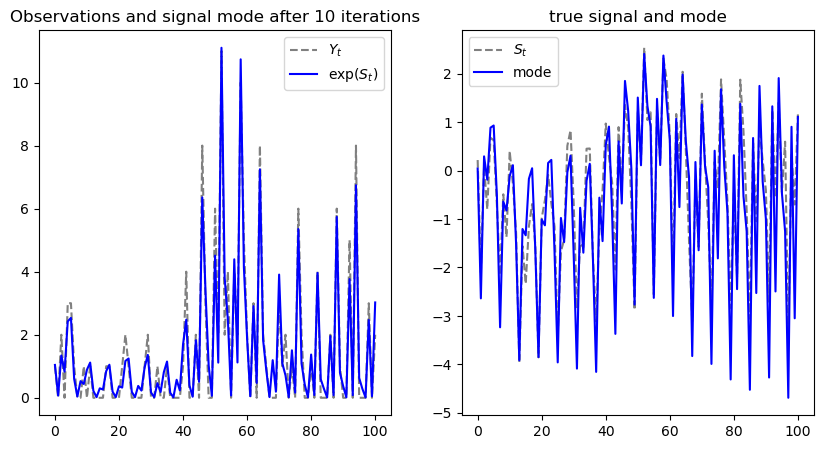

In [7]:
s_order = 5
model = nb_pgssm_running_example(
    s_order=s_order, Sigma0_seasonal=jnp.eye(s_order - 1), x0_seasonal=jnp.zeros(s_order- 1)
)

key = jrn.PRNGKey(511)
key, subkey = jrn.split(key)
N = 1
(X,), (Y,) = simulate_pgssm(model, N, subkey)

proposal, info = laplace_approximation(Y, model, 10)
smooth_signal = posterior_mode(proposal)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title(f"Observations and signal mode after {info.n_iter} iterations")
ax1.plot(Y[:], linestyle="--", color="gray", label="$Y_t$")
ax1.plot(jnp.exp(smooth_signal), color="blue", label="$\\exp (S_t) $")
ax2.set_title("true signal and mode")
ax2.plot(vmap(jnp.matmul)(model.B, X), linestyle="--", color="gray", label="$S_t$")
ax2.plot(smooth_signal, color="blue", label="mode")
ax1.legend()
ax2.legend()

# unique legend
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
plt.show()

The default implementation of the `mode_estimation` method uses automatic differentiation to evaluate the first and second derivatives necessary to implement the LA. You can also provide the derivatives yourself, e.g. for efficiency or numerical stability.

In [8]:
#| code-fold: True
r = 20.
def nb_log_lik(s_ti, r_ti, y_ti):
    return jnp.sum(y_ti * jnp.log(expit(s_ti - jnp.log(r_ti))) - r_ti * jnp.log(jnp.exp(s_ti) + r_ti))

def d_nb_log_lik(s_ti, r_ti, y_ti):
    return y_ti - (y_ti + r_ti) * expit(s_ti - jnp.log(r_ti))

def dd_nb_log_lik(s_ti, r_ti, y_ti):
    return -(y_ti + r_ti) * expit(s_ti - jnp.log(r_ti)) * (1 - expit(s_ti - jnp.log(r_ti)))

print("10 iterations of LA with AD ")
%timeit laplace_approximation(Y, model, 10)[0][0].block_until_ready()
print("10 iterations of LA with analytical gradients")
%timeit laplace_approximation(Y, model, 10, nb_log_lik, d_nb_log_lik, dd_nb_log_lik)[0][0].block_until_ready()

10 iterations of LA with AD 
2.02 s ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10 iterations of LA with analytical gradients
1.81 s ± 54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# | hide
import nbdev

nbdev.nbdev_export()